In [1]:
# TODO
# turn up aug settings
# more callbacks
# longer training

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.vision.models.xresnet import xresnet50

import pandas as pd

In [4]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [5]:
y = pd.read_csv(labels_path, index_col='filename')

In [6]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

pet_block = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y = lambda x: get_y_func(x),
    splitter=RandomSplitter()
)

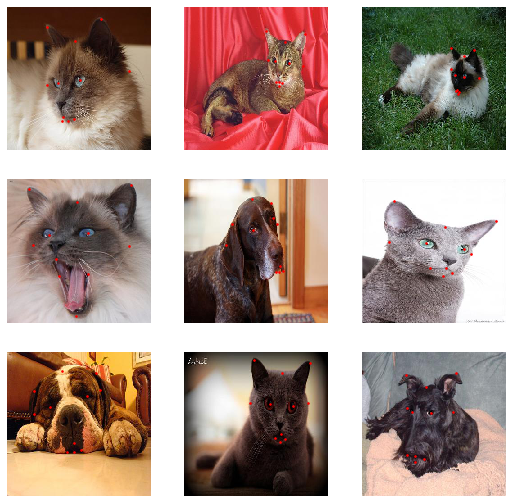

In [7]:
pet_dataloaders = pet_block.dataloaders(
    images_path,
    bs=32,
    batch_tfms=[
        *aug_transforms(size=(320,320)), 
        Normalize.from_stats(*imagenet_stats),
    ]
)
pet_dataloaders.show_batch(max_n=9, vmin=5, vmax=5)

In [8]:
pet_dataloaders.c = pet_dataloaders.after_item.c
pet_dataloaders.train_ds.loss_func = MSELossFlat()

In [18]:
learn = cnn_learner(
    pet_dataloaders, 
    xresnet50, 
    opt_func=partial(Adam, wd=0.01, eps=1e-8)
).to_fp16()
learn.path = Path('..')

In [11]:
learn.fit_one_cycle(2, slice(1e-2))

epoch,train_loss,valid_loss,time
0,0.532958,0.086858,03:02


In [12]:
learn.unfreeze()

In [13]:
learn.fit_one_cycle(10, slice(1e-4, 1e-2), cbs=[SaveModelCallback()])

epoch,train_loss,valid_loss,time
0,0.176307,0.152748,03:49
1,0.102639,0.079108,03:42
2,0.072213,0.066484,03:42
3,0.065604,0.065313,03:42
4,0.061554,0.063358,03:42


In [14]:
# learn.predict(pet_dataloaders.train_ds.items[0])

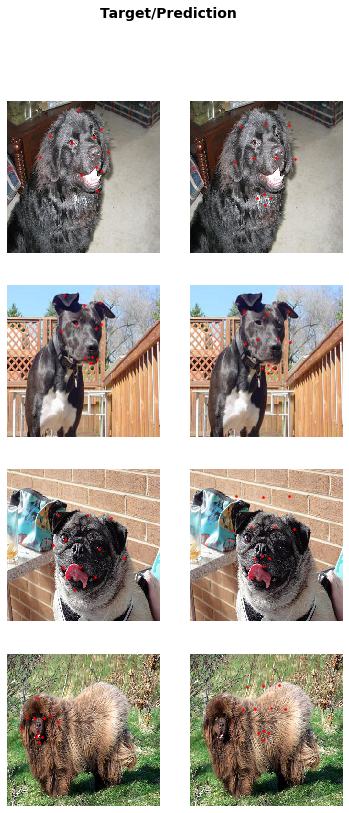

In [17]:
learn.show_results(max_n=10)

In [3]:
# learn.summary()